In [1]:
import cmocean.cm as cm
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
# import statfieldodels.api as sm
import xarray as xr
from salishsea_tools import viz_tools

In [2]:
cmap = cm.rain #'pink_r'#cm.rain #cm.ice_r #'ocean_r' #'pink_r'

In [3]:
foramt = "{:.3}"
myformat = {'bias': foramt, 'rmse': foramt, 'crmse':foramt, 'swillmott': foramt, 'slopedev': foramt, 'const': foramt,
                         'systematic': foramt, 'nonsystematic':foramt, 
                    'spread': foramt}

def use_f_2(x):
    return "%.2f" % x

In [204]:
def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()

def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

def crmse(rmse, bias):
    return (np.sqrt(rmse**2 - bias**2))

def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())
    
def slope_inter(df, obs, mod):
    X = df[obs]
    y = df[mod]
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
#    print (model.summary())
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
    return model.params[obs], model.params['const'], systematic, nonsyst

def wolfram_perp(df, obsin, modin):
    
    mod = np.array(df[modin][(df[modin] == df[modin]) & (df[obsin] == df[obsin])])
    obs = np.array(df[obsin][(df[modin] == df[modin]) & (df[obsin] == df[obsin])])
    
    n = mod.shape[0]

    y2s = (mod**2).sum()
    ys = mod.sum()
    x2s = (obs**2).sum()
    xs = obs.sum()
    xys = (mod * obs).sum()
    B = 0.5 * ( (y2s - ys**2/n) - (x2s - xs**2/n)) / (xs * ys/n - xys)
    b1 = -B + np.sqrt(B*B + 1)
    a1 = (ys - b1*xs)/n
    predictions = a1 + b1 * df[obsin]
    
    nonsyst = np.sqrt(((df[modin] - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obsin])**2).mean())
  
    return a1, b1, systematic, nonsyst

def wolfram_perp2( obs, mod):
    
    n = mod.shape[0]

    y2s = (mod**2).sum()
    ys = mod.sum()
    x2s = (obs**2).sum()
    xs = obs.sum()
    xys = (mod * obs).sum()
    B = 0.5 * ( (y2s - ys**2/n) - (x2s - xs**2/n)) / (xs * ys/n - xys)
    b1 = -B + np.sqrt(B*B + 1)
    a1 = (ys - b1*xs)/n
    predictions = a1 + b1 * obs
    
    nonsyst = np.sqrt(((mod - predictions)**2).mean())
    systematic = np.sqrt(((predictions - obs)**2).mean())
  
    return a1, b1, systematic, nonsyst

def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean() 

def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        if 'ferry' in piece:
            nextpiece['k'] = 0
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
#    temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
    return temp1

def filter_bad_data(temp1):
# bad data in Puget Sound (pugts)
    temp1_nohook = temp1[(temp1.Lat > 47.30) | (temp1.Lon < -122.5) | (temp1.Z < 5)  ]
# bad onc data
 #   temp1_nobox_nohook = temp1_nohook[(temp1_nohook['depth (m)'] != 107) | (temp1_nohook.SA > 29)]
# bad ferry data
  #  temp1_clean = temp1_nobox_nohook[((temp1_nobox_nohook.SA > 0.2) | (temp1_nobox_nohook.mod_vosaline - temp1_nobox_nohook.SA < 20)) 
  #                                   & ((temp1_nobox_nohook.Lon > -123.8) | (temp1_nobox_nohook.SA > 14))]
    return temp1_nohook

def plot_and_stats(temp1, name, idepth, jdepth, fig, ax, whichdepths, reverse, string, boxes=False, box=None, boxname=None):
    print (temp1[temp1.k <= idepth])
    if boxes: # boxes for sebregion box
        corn = box
        select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
        shift_text = 0.94
    else:
        select = temp1[(temp1.k >= idepth) & (temp1.k < jdepth)]
        shift_text = 1
    
    print (swillmott(select, 'LCEWEL01', 'mod_vozocrtx'))
    
    if reverse:
        one = modn
        two = obsn
    else:
        one = obsn
        two = modn
    
    counts, xedges, yedges, color = ax.hist2d(select[one], 
                                              select[two], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
    fig.colorbar(color, ax=ax)
   
   #calculate stats
    number, tbias = bias(select, one, two)
    trmse = rmse(select, one, two)
    tcrmse = crmse(trmse, tbias)
    tswillmott = swillmott(select, one, two)
#    m, c, syst, nonsyst = slope_inter(select, one, two)
    a1, b1, syst, nonsyst = wolfram_perp(select, one, two)
    tspread = spread(select, one, two)
    ax.plot([vmin, vmax], [vmin, vmax], 'k-');
    xr = np.arange(vmin, vmax, 0.01)
#    ax.plot(xr, c + m * xr, 'r-');
    ax.plot(xr, a1 + b1 * xr, 'r-')
    sc = scale/12
    sh = 2*sc-1
    bot = scale
    top = bot + 2*sh
    # ax.arrow(sc+vmin, bot+vmin, 0, sh-np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(sc+vmin, top+vmin, 0, -sh+np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(2*sc+vmin, bot+vmin, 0, sh-syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(2*sc+vmin, top+vmin, 0, -sh+syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(3*sc+vmin, bot+vmin, 0, sh-nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(3*sc+vmin, top+vmin, 0, -sh+nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
           'crmse': tcrmse,
          'swillmott': tswillmott,
          'slopedev': 1-b1,
          'const': a1,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    # ax.text(0.8*sc+vmin, 0.9*bot*shift_text+vmin, 'bias', rotation=90)
    # ax.text(1.8*sc+vmin, 0.72*bot*shift_text+vmin-shift_text, 'systematic', rotation=90)
    # ax.text(2.8*sc+vmin, 0.6*bot*shift_text+vmin-shift_text, 'non-systematic', rotation=90)
    
    ax.set_title(f'{name}, {field} {whichdepths}{string}');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2, counts

def highlight_max_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''

    is_max = abs(s) == abs(s).max()
    is_min = abs(s) == abs(s).min()
    color = []
    for v, v2 in zip(is_max, is_min):
        if v:
            color.append('red')
        elif v2:
            color.append('darkgreen')
        else:
            color.append('black')
    return ['color: %s' % color[i] for i in range(len(is_max))]

def plot_allyears(years, years_psf, years_pug, years_onc, years_ferry, idepth, jdepth, whichdepths, reverse=False):
    if reverse:
        string = '_reverse'
    else:
        string = ''
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    startyear = min(years)# years_psf[0], years_pug[0]), years_onc[0])
    endyear = max(years) #years_psf[-1], years_pug[-1]), years_onc[-1])
    fig.suptitle(f'Year {startyear}-{endyear}')
    print (idepth, jdepth)
    pieces1 = []
    for year in years:
        pieces1.append(
              f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_CIOOS_{year}0101_{year}1231.csv')
    # for year in years_psf:
    #     pieces1.append(
    #         f'//data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_psfts_{year}0101_{year}1231.csv')
    # for year in years_pug:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    #      #   f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    # for year in years_onc:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_onc_{year}0101_{year}1231.csv')
    # for year in years_ferry:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ferry_{year}0101_{year}1231.csv')
    temp1 = read_pieces(pieces1)
    d202111, counts1 = plot_and_stats(filter_bad_data(temp1), '202111', idepth, jdepth, fig, axs[0], whichdepths, reverse, string)

    alltogether = d202111
    
    fig.savefig(f'{whichdepths}_{field}{string}_201905_202111_for_allyears.png')
    
    # f = open(f'./{whichdepths}_{field}{string}_201905_202111_for_allyears_table.tex', 'w')
    # f.write(alltogether.to_latex(column_format='lcccccccccc', 
    #         formatters=[None, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2]))
    # f.close()
    return alltogether, counts1

# def get_combined(years, years_psf, years_pug, years_onc, years_ferry, idepth, jdepth, whichdepths, reverse=False):
#     if reverse:
#         string = '_reverse'
#     else:
#         string = ''
        
#     pieces1 = []
#     for year in years:
#         pieces1.append(
#               f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_CIOOS_{year}0101_{year}1231.csv')
#     # for year in years_psf:
#     #     pieces1.append(
#     #         f'//data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_psfts_{year}0101_{year}1231.csv')
#     # for year in years_pug:
#     #     pieces1.append(
#     #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
#     #      #   f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
#     # for year in years_onc:
#     #     pieces1.append(
#     #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_onc_{year}0101_{year}1231.csv')
#     # for year in years_ferry:
#     #     pieces1.append(
#     #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ferry_{year}0101_{year}1231.csv')
#     temp1 = read_pieces(pieces1)
    
#     # f.close()
#     return temp1

def get_stats(temp1, name, idepth, jdepth, whichdepths, reverse, string, boxes=False, box=None, boxname=None):
    if boxes: # boxes for sebregion box
        corn = box
        select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
        shift_text = 0.94
    else:
        select = temp1[(temp1.k >= idepth) & (temp1.k < jdepth)]
        shift_text = 1
    
    # print (swillmott(select, 'LCEWEL01', 'mod_vozocrtx'))
    
    if reverse:
        one = modn
        two = obsn
    else:
        one = obsn
        two = modn
   
   #calculate stats
    number, tbias = bias(select, one, two)
    trmse = rmse(select, one, two)
    tcrmse = crmse(trmse, tbias)
    tswillmott = swillmott(select, one, two)
    a1, b1, syst, nonsyst = wolfram_perp(select, one, two)
    tspread = spread(select, one, two)
    xr = np.arange(vmin, vmax, 0.01)
    sc = scale/12
    sh = 2*sc-1
    bot = scale
    top = bot + 2*sh

    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
           'crmse': tcrmse,
          'swillmott': tswillmott,
          'slopedev': 1-b1,
          'const': a1,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}

    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2

def get_combined(years, years_psf, years_pug, years_onc, years_ferry, idepth, jdepth, whichdepths, reverse=False,gridN='gridU'):
    if reverse:
        string = '_reverse'
    else:
        string = ''
        
    pieces1 = []
    for year in years:
        if gridN=='gridV':
            pieces1.append(
              f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/gridV/ObsModel_202111_CIOOS_gridV_{year}0101_{year}1231.csv')
        else:
            pieces1.append(
              f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_CIOOS_gridU_{year}0101_{year}1231.csv')
    # for year in years_psf:
    #     pieces1.append(
    #         f'//data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_psfts_{year}0101_{year}1231.csv')
    # for year in years_pug:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    #      #   f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
        if gridN=='gridU':
            pieces1.append(
              f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_gridU_{year}0101_{year}1231.csv')
        else:
            pieces1.append(
                f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_{year}0101_{year}1231.csv')
    # for year in years_ferry:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ferry_{year}0101_{year}1231.csv')
    temp1 = read_pieces(pieces1)
    data_filter = temp1[temp1[modn].notna()]
    d202111 = get_stats(filter_bad_data(data_filter),field , idepth, jdepth, whichdepths, reverse, string)
    
    return data_filter,d202111

In [63]:
field = 'u-vel'
obsn = 'LCEWEL01'
modn = 'mod_vozocrtx'
gridn = 'gridU'
vmax = 0.6
vmin = -0.6
dbin = 0.01
scale = 24

idepth = 0
jdepth = 39

data_uvel,d_uvel = get_combined([2008,2009,2010,2012,2021,2022]
                                          , []#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , []#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , []#[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                          , idepth, jdepth, 'alldepths')

d_uvel.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,161492,-0.00268,0.132,0.132,0.37,0.68,0.00215,0.104,0.0689,0.731


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,161492,-0.00268,0.132,0.132,0.37,0.68,0.00215,0.104,0.0689,0.731


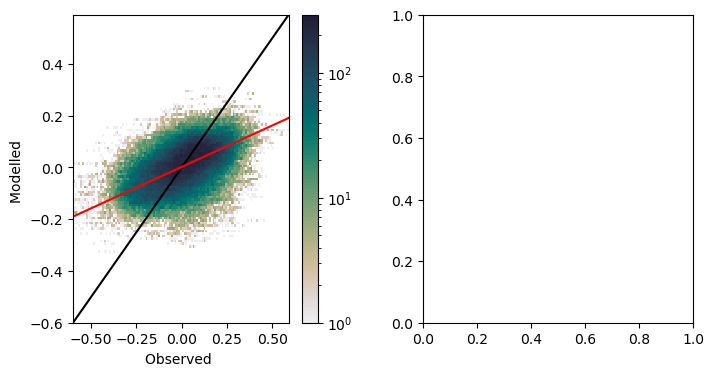

In [74]:
fig,[ax,ax2] = plt.subplots(1,2,figsize=(8,4))
counts, xedges, yedges, color = ax.hist2d( data_uvel['LCEWEL01'],data_uvel['mod_vozocrtx'],
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
ax.set_xlabel(f'Observed ')
ax.set_ylabel(f'Modelled ')
fig.colorbar(color, ax=ax)
ax.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_uvel,obsn,modn)
line = a1+np.arange(vmin, vmax, 0.01)*b1

# slope,intercept = np.polyfit(data['mod_vozocrtx'],data['LCEWEL01'],1)
# line = slope*np.arange(vmin,vmax,0.01)+intercept
ax.plot(np.arange(vmin,vmax,0.01),line,'r')

# counts, xedges, yedges, color = ax2.hist2d(sal_data['SA'],sal_data['mod_vosaline'], 
#                                            bins=np.arange(0, 36, 0.5), norm=LogNorm(), cmap=cmap);
# ax2.set_xlabel('Observed salinity (g/kg)')
# ax2.set_ylabel('Modelled salinity (g/kg)')
# fig.colorbar(color, ax=ax2)
# ax2.plot(np.arange(0,36,0.5),np.arange(0,36,0.5),color='k')
# a1,b1,stm,nstm = wolfram_perp(sal_data,'SA','mod_vosaline')
# line = a1+np.arange(0, 36, 0.5)*b1
# ax2.plot(np.arange(0, 36, 0.5),line,'r')

fig.subplots_adjust(wspace=0.3)

display(d_uvel.style.format(myformat).apply(highlight_max_min))
# d_uvel.style.format(myformat).apply(highlight_max_min)


### V-velocity

In [213]:
field = 'v-vel'
obsn = 'LCNSEL01'
modn = 'mod_vomecrty'
gridn = 'gridV'
vmax = 0.6
vmin = -0.6
dbin = 0.01
scale = 24

idepth = 0
jdepth = 39

data,d_vvel = get_combined([2008,2009,2010,2012,2021,2022]
                                          , []#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , []#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , []#[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                          , idepth, jdepth, 'alldepths',gridN=gridn)

d_vvel.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,161492,-0.0122,0.0994,0.0987,0.14,-0.25,-0.00577,0.0341,0.107,-0.406


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,161492,-0.00268,0.132,0.132,0.37,0.68,0.00215,0.104,0.0689,0.731


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,161492,-0.0122,0.0994,0.0987,0.14,-0.25,-0.00577,0.0341,0.107,-0.406


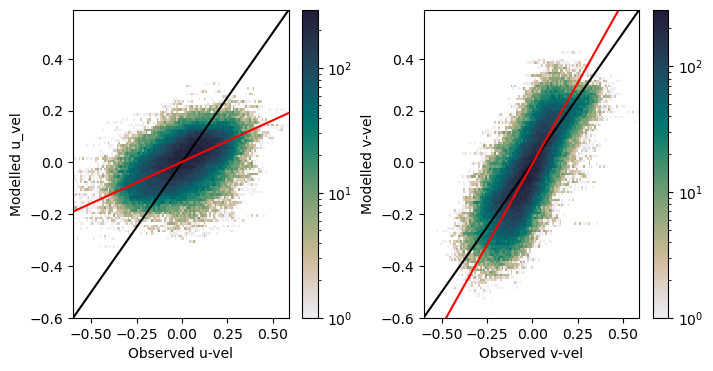

In [67]:
fig,[ax,ax2] = plt.subplots(1,2,figsize=(8,4))

counts, xedges, yedges, color = ax.hist2d( data_uvel['LCEWEL01'],data_uvel['mod_vozocrtx'],
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(),cmap=cmap);
ax.set_xlabel(f'Observed u-vel')
ax.set_ylabel(f'Modelled u_vel')
fig.colorbar(color, ax=ax)
ax.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_uvel,'LCEWEL01','mod_vozocrtx')
line = a1+np.arange(vmin, vmax, 0.01)*b1
# slope,intercept = np.polyfit(data_uvel['LCEWEL01'],data_uvel['mod_vozocrtx'],1)
# line = slope*np.arange(vmin,vmax,0.01)+intercept
ax.plot(np.arange(vmin,vmax,0.01),line,'r')
counts, xedges, yedges, color = ax2.hist2d( data['LCNSEL01'],data['mod_vomecrty'],
                                           bins=np.arange(vmin, vmax, dbin),norm=LogNorm(), cmap=cmap);
ax2.set_xlabel(f'Observed v-vel')
ax2.set_ylabel(f'Modelled v-vel')
fig.colorbar(color, ax=ax2)
ax2.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data,obsn,modn)
line = a1+np.arange(vmin, vmax, 0.01)*b1

# slope,intercept = np.polyfit(data['LCNSEL01'],data['mod_vomecrty'],1)
# line = slope*np.arange(vmin,vmax,0.01)+intercept
ax2.plot(np.arange(vmin,vmax,0.01),line,'r')

fig.subplots_adjust(wspace=0.3)

display(d_uvel.style.format(myformat).apply(highlight_max_min))
d_vvel.style.format(myformat).apply(highlight_max_min)

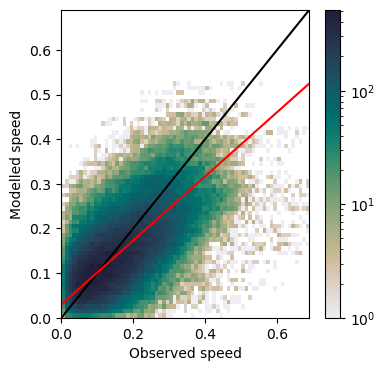

In [18]:
obs_speed = np.sqrt(data_uvel['LCEWEL01']**2+data['LCNSEL01']**2)
mod_speed = np.sqrt(data_uvel['mod_vozocrtx']**2+data['mod_vomecrty']**2)
vmin = 0
vmax = 0.7

fig,ax = plt.subplots(1,1,figsize=(4,4))

counts, xedges, yedges, color = ax.hist2d( obs_speed,mod_speed,
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(),cmap=cmap);
ax.set_xlabel(f'Observed speed')
ax.set_ylabel(f'Modelled speed')
fig.colorbar(color, ax=ax)
ax.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp2(obs_speed,mod_speed)
line = a1+np.arange(vmin, vmax, 0.01)*b1
# slope,intercept = np.polyfit(obs_speed,mod_speed,1)
# line = slope*np.arange(vmin,vmax,0.01)+intercept
ax.plot(np.arange(vmin,vmax,0.01),line,'r')

In [229]:
data_uvel['mod_east_vel'] = data_uvel['mod_vozocrtx']*np.cos(np.deg2rad(29)) - data['mod_vomecrty']*np.sin(np.deg2rad(29))
data['mod_north_vel'] = data_uvel['mod_vozocrtx']*np.sin(np.deg2rad(29)) + data['mod_vomecrty']*np.cos(np.deg2rad(29))

modn = 'mod_east_vel'
obsn = 'LCEWEL01'

d_uvel = get_stats(filter_bad_data(data_uvel),'u-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

modn = 'mod_north_vel'
obsn = 'LCNSEL01'

d_uvel = get_stats(filter_bad_data(data),'v-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

display(d_uvel.style.format(myformat).apply(highlight_max_min))
display(d_vvel.style.format(myformat).apply(highlight_max_min))

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,161492,-0.0053,0.0894,0.0892,0.14,0.0371,-0.00626,0.0071,0.0875,0.055


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,161492,-0.0122,0.0994,0.0987,0.14,-0.25,-0.00577,0.0341,0.107,-0.406


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,161492,-0.0053,0.0894,0.0892,0.14,0.0371,-0.00626,0.0071,0.0875,0.055


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,161492,-0.0122,0.0994,0.0987,0.14,-0.25,-0.00577,0.0341,0.107,-0.406


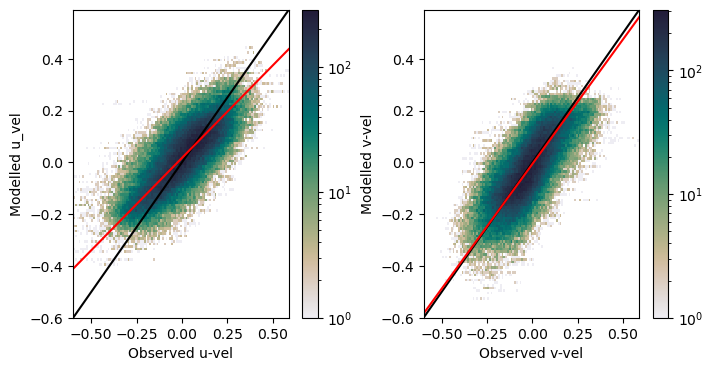

In [224]:
vmax = 0.6
vmin = -0.6

fig,[ax,ax2] = plt.subplots(1,2,figsize=(8,4))

counts, xedges, yedges, color = ax.hist2d( data_uvel['LCEWEL01'],data_uvel['mod_east_vel'],
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(),cmap=cmap);
ax.set_xlabel(f'Observed u-vel')
ax.set_ylabel(f'Modelled u_vel')
fig.colorbar(color, ax=ax)
ax.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_uvel,'LCEWEL01','mod_east_vel')
line = a1+np.arange(vmin, vmax, 0.01)*b1
# slope,intercept = np.polyfit(data_uvel['i_vel'],data_uvel['mod_vozocrtx'],1)
# line = slope*np.arange(vmin,vmax,0.01)+intercept
ax.plot(np.arange(vmin,vmax,0.01),line,'r')
counts, xedges, yedges, color = ax2.hist2d( data['LCNSEL01'],data['mod_north_vel'],
                                           bins=np.arange(vmin, vmax, dbin),norm=LogNorm(), cmap=cmap);
ax2.set_xlabel(f'Observed v-vel')
ax2.set_ylabel(f'Modelled v-vel')
fig.colorbar(color, ax=ax2)
ax2.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data,'LCNSEL01','mod_north_vel')
line = a1+np.arange(vmin, vmax, 0.01)*b1

# slope,intercept = np.polyfit(data['LCNSEL01'],data['mod_vomecrty'],1)
# line = slope*np.arange(vmin,vmax,0.01)+intercept
ax2.plot(np.arange(vmin,vmax,0.01),line,'r')

fig.subplots_adjust(wspace=0.3)

display(d_uvel.style.format(myformat).apply(highlight_max_min))
d_vvel.style.format(myformat).apply(highlight_max_min)


Text(0.5, 0.98, 'V-velocity')

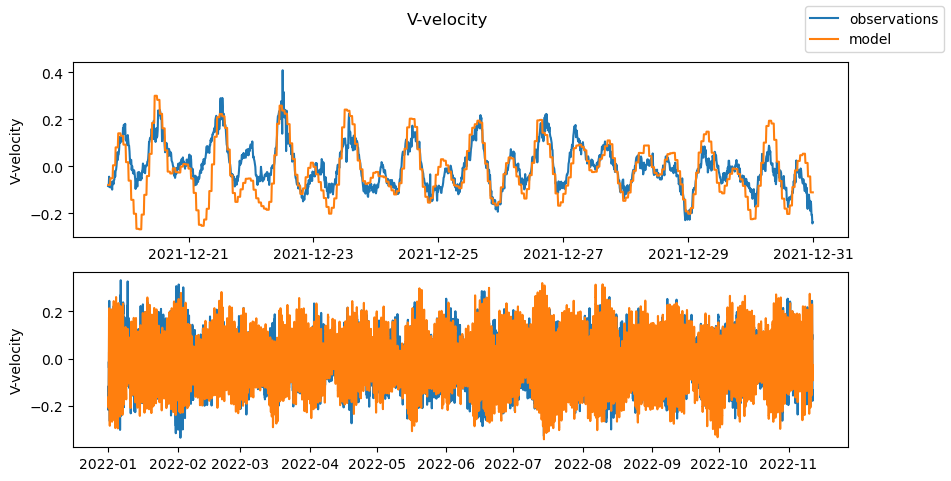

In [230]:
data['dtime'] = pd.to_datetime(data['dtUTC'])
data_2021 = data[(data['dtime'].dt.year == 2021) ]
data_2022 = data[(data['dtime'].dt.year == 2022) ]

fig,[ax,ax2] = plt.subplots(2,1,figsize=(10,5))
ax2.plot(data_2022['dtime'],data_2022['LCNSEL01'],label='observations')
ax2.plot(data_2022['dtime'],data_2022['mod_north_vel'],label='model')
ax.plot(data_2021['dtime'],data_2021['LCNSEL01'])
ax.plot(data_2021['dtime'],data_2021['mod_north_vel'])
ax.set_ylabel('V-velocity')
ax2.set_ylabel('V-velocity')
fig.legend()
fig.suptitle('V-velocity')

Text(0.5, 0.98, 'U-velocity')

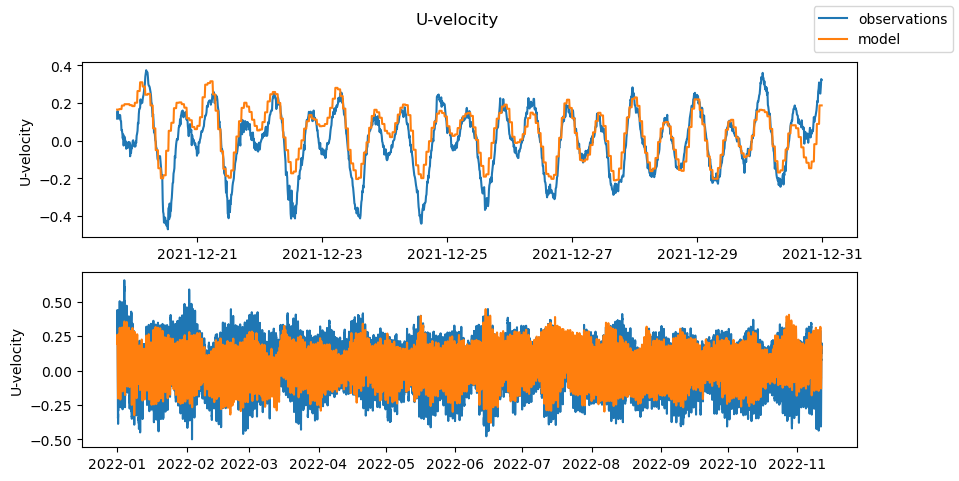

In [218]:
data_uvel['dtime'] = pd.to_datetime(data_uvel['dtUTC'])
data_uvel_2021 = data_uvel[(data_uvel['dtime'].dt.year == 2021) ]
data_uvel_2022 = data_uvel[(data_uvel['dtime'].dt.year == 2022) ]

fig,[ax,ax2] = plt.subplots(2,1,figsize=(10,5))
ax2.plot(data_uvel_2022['dtime'],data_uvel_2022['LCEWEL01'],label='observations')
ax2.plot(data_uvel_2022['dtime'],data_uvel_2022['mod_east_vel'],label='model')
ax.plot(data_uvel_2021['dtime'],data_uvel_2021['LCEWEL01'])
ax.plot(data_uvel_2021['dtime'],data_uvel_2021['mod_east_vel'])

ax.set_ylabel('U-velocity')
ax2.set_ylabel('U-velocity')
fig.legend()
fig.suptitle('U-velocity')

Text(0.5, 0.98, 'Speed')

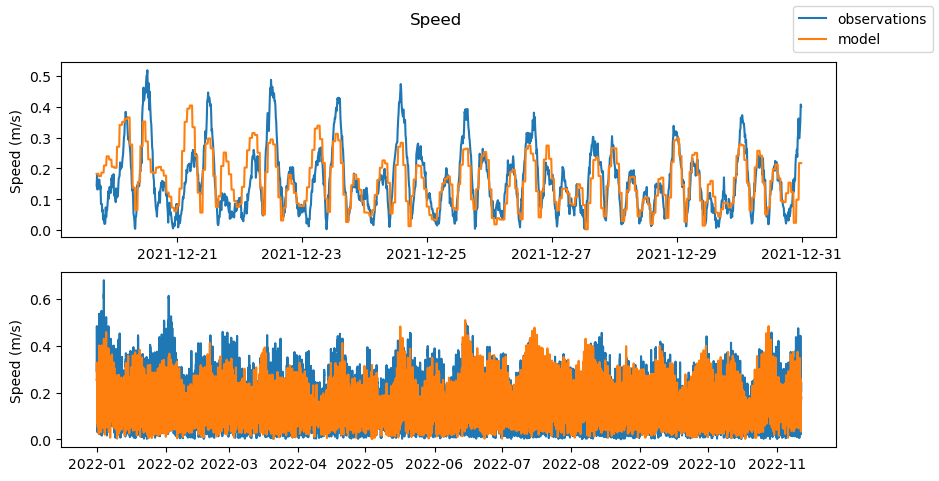

In [158]:
data['dtime'] = pd.to_datetime(data['dtUTC'])
data_2021 = data[(data['dtime'].dt.year == 2021) ]
data_2022 = data[(data['dtime'].dt.year == 2022) ]

fig,[ax,ax2] = plt.subplots(2,1,figsize=(10,5))
ax2.plot(data_2022['dtime'],data_2022['obs_speed'],label='observations')
ax2.plot(data_2022['dtime'],data_2022['mod_speed'],label='model')
ax.plot(data_2021['dtime'],data_2021['obs_speed'])
ax.plot(data_2021['dtime'],data_2021['mod_speed'])
ax.set_ylabel('Speed (m/s)')
ax2.set_ylabel('Speed (m/s)')
fig.legend()
fig.suptitle('Speed')

Model slightly underestimating 

### Look @ ONC data

In [210]:
field = 'u-vel'
obsn = 'current_velocity_east'
modn = 'mod_vozocrtx'
gridn = 'gridU'
vmax = 0.9
vmin = -0.3
dbin = 0.01
scale = 24

idepth = 0
jdepth = 39

data,d_vvel = get_combined([]#[2008,2009,2010,2012,2021,2022]
                                          , []#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , [2012,2013]#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , []#[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                          , idepth, jdepth, 'alldepths',gridN=gridn)

d_vvel.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,17737,0.0116,0.309,0.308,0.312,-0.384,-0.0652,0.107,0.363,-0.376


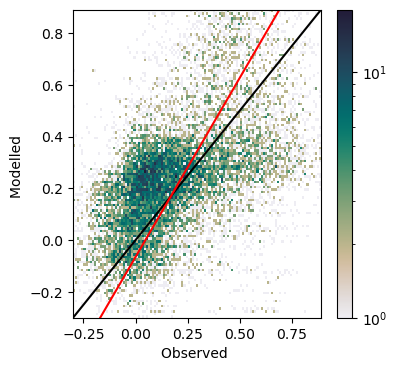

In [211]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
counts, xedges, yedges, color = ax.hist2d( data['current_velocity_east'],data['mod_vozocrtx'],
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
ax.set_xlabel(f'Observed ')
ax.set_ylabel(f'Modelled ')
fig.colorbar(color, ax=ax)
ax.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data,obsn,modn)
line = a1+np.arange(vmin, vmax, 0.01)*b1

# slope,intercept = np.polyfit(data['mod_vozocrtx'],data['LCEWEL01'],1)
# line = slope*np.arange(vmin,vmax,0.01)+intercept
ax.plot(np.arange(vmin,vmax,0.01),line,'r')